In [388]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [872]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [877]:
# run this ceil for different data sets

α = [1.0, -2.0] # single index for x
θ = [2.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n_ = 250
n0 = 500
n1 = 750
n2 = 1000
n3 = 1500
n = n_

fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 0 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

  0.359043 seconds (2.09 M allocations: 551.135 MiB, 41.52% gc time)
Estimation of index coefs: 
̂α => [0.4524530544278638; -0.8917882223593765]
̂γ => [0.04412214469269987, 0.3919759185196912]
Estimation of linear coefs: 
̂θ => [1.9765241803098081 1.002799072817672]
̂β => [-0.21515623733894282, -0.0769808578428508]
square of integral: 7.939960807374749


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

width = 2.0615779265321508
dy = 0.8164561873866151


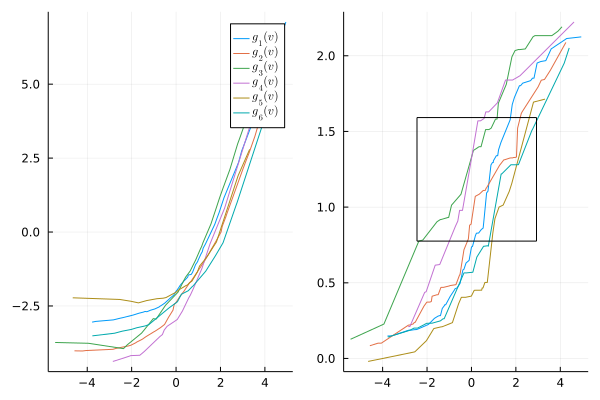

In [878]:
g = zeros(n)
dg = zeros(n)
v = X * alpha1 
yz = y - X * transpose(theta)
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h * n/1000
    vkmax = maximum(vk) - h * n/1000

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

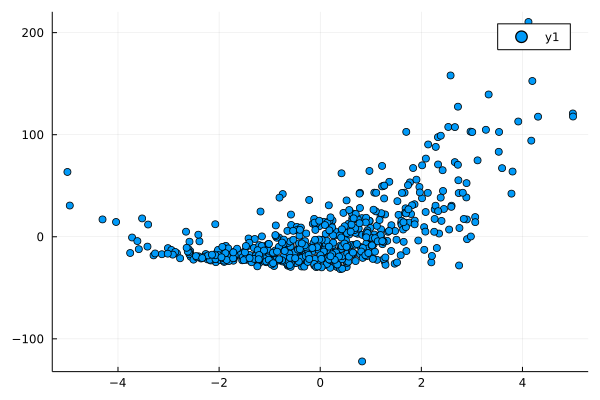

In [308]:
scatter(X[:,2], y)

# Monte Carlo Simulation

In [621]:
Threads.nthreads()

2

In [1162]:
include("MonteCarloSIM.ji")

α = [1.0, -3.0] # single index for x
θ = [3.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.0, 0.5] # single index for z
β = [-1.0, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = n2
fx = 2
dist = 0 # Cauchy
rep = 100 # MC rept. times

100

In [ ]:
Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

In [ ]:
mb = mean(Beta, dims = 1)

In [ ]:
mt = mean(Theta, dims = 1)

In [ ]:
ma = mean(Alpha, dims = 1)

In [1157]:
mg = mean(Gamma, dims = 1) 

1×2 Matrix{Float64}:
 -0.000399851  0.0965822

In [1158]:
ratio = norm(α) / norm(γ)

6.324555320336759

In [1159]:
norm(ma)/norm(mg)/ratio

1.6370555257030321

In [1161]:
mg * 1.5 * 1/ma[1]

1×2 Matrix{Float64}:
 -0.00189716  0.458252

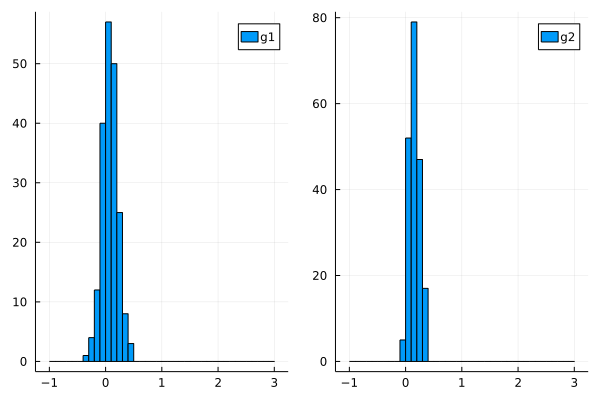

In [125]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

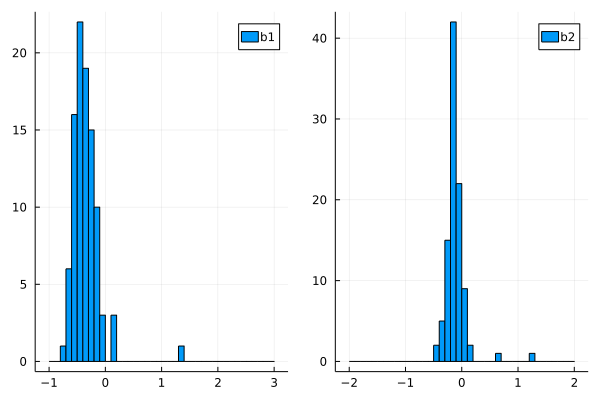

In [81]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

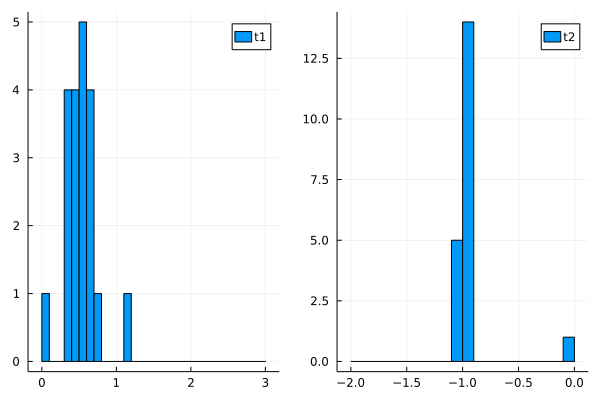

In [91]:
p1 = histogram(Theta[:,1], bins = 0:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

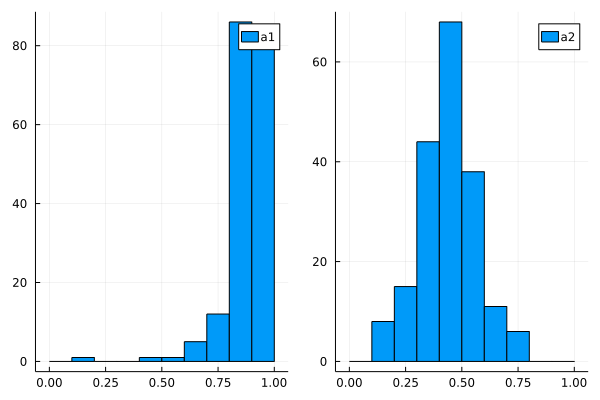

In [35]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))